In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from caits.visualization import plot_signal
from IPython.display import Audio

In [2]:
from caits.loading import wav_specs_check
audio_params = wav_specs_check(wav_file_path="data/dataset_speech_commands/yes/0ab3b47d_nohash_0.wav")

Sample rate: 16000 Hz
Mono


In [3]:
SAMPLE_RATE = audio_params["framerate"]
SAMPLE_RATE

16000

In [4]:
data_path = "data/dataset_speech_commands"

In [5]:
from caits.loading import audio_loader
cough_data_dict = audio_loader(data_path, target_sr=SAMPLE_RATE)

Loading audio files: 100%|██████████| 799/799 [00:00<00:00, 5983.14it/s]


In [6]:
from caits.dataset import Dataset

data = Dataset(
    X=cough_data_dict["X"],
    y=cough_data_dict["y"],
    id=cough_data_dict["id"],
)

data

Dataset with 799 instances

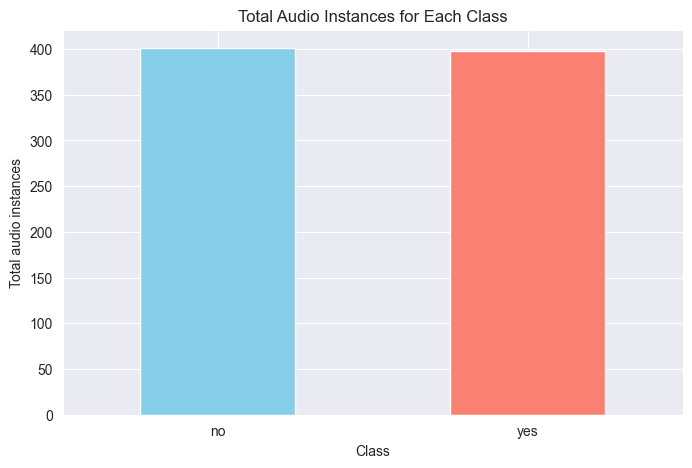

In [7]:
df = data.to_df()
df.y.value_counts().plot(kind="bar", color=['skyblue', 'salmon'], figsize=(8, 5))
# Set labels and title
plt.xlabel('Class')
plt.ylabel('Total audio instances')
plt.title('Total Audio Instances for Each Class')

# Display the plot
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

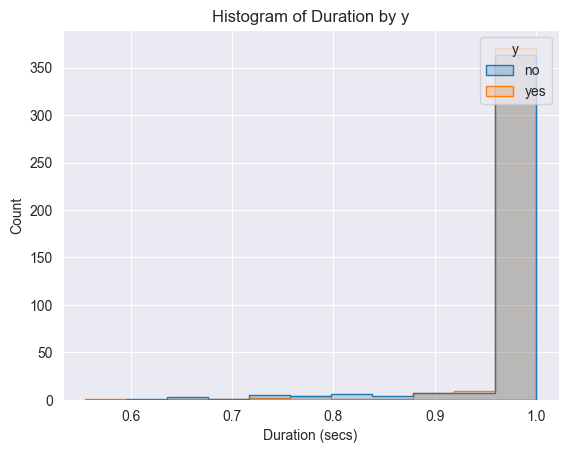

In [8]:
df["duration"] = df.X.apply(len) / SAMPLE_RATE

sns.histplot(data=df, x="duration", hue="y", element="step", common_norm=False)

plt.xlabel('Duration (secs)')
plt.ylabel("Count")
plt.title('Histogram of Duration by y')
plt.show()

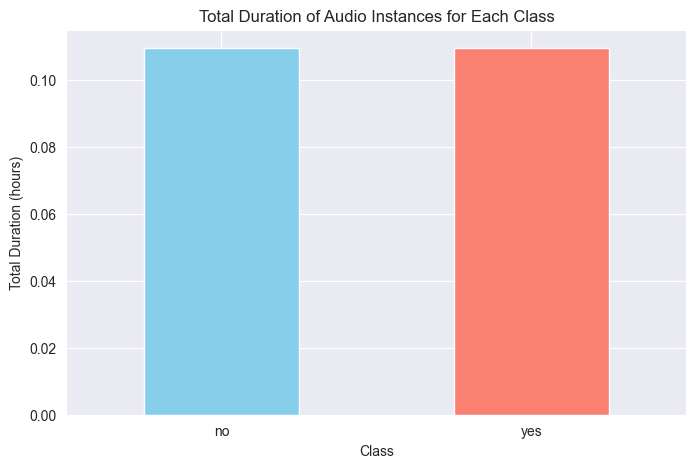

In [9]:
# Convert duration from seconds to hours
df['duration_hours'] = df['duration'] / 3600

# Group by 'y' column and calculate total duration for each class
total_duration_per_class = df.groupby('y')['duration_hours'].sum()

# Plot the total duration for each class
total_duration_per_class.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8, 5))

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Total Duration (hours)')
plt.title('Total Duration of Audio Instances for Each Class')

# Display the plot
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

In [10]:
WS_SECONDS = .2
OVERLAP_PERCENTAGE = 0.5 # percentage

WS_SAMPLES = int(WS_SECONDS * SAMPLE_RATE)
OVERLAP_SAMPLES = int(OVERLAP_PERCENTAGE * WS_SAMPLES)

WS_SAMPLES, OVERLAP_SAMPLES

(3200, 1600)

# Load `caits` FunctionTransformer

In [11]:
from sklearn.pipeline import Pipeline
from caits.transformers import FunctionTransformer

# Pipeline - Trimming the audio

In [12]:
from caits.preprocessing import trim_signal

trimmer_transformer = FunctionTransformer(trim_signal, axis=0, epsilon=0.075)

In [13]:
pipe_trim = Pipeline([
    ("trimmer", trimmer_transformer)
])

In [14]:
data_trimmed = pipe_trim.fit_transform(data)

In [15]:
data_trimmed

Dataset with 799 instances

In [16]:
instance = data_trimmed[0][0]["Ch_1"].values

In [17]:
instance.shape

(1225,)

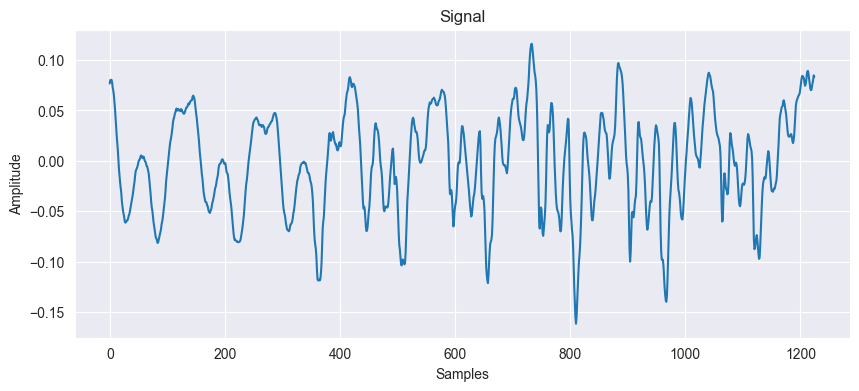

In [18]:
plot_signal(instance, SAMPLE_RATE, return_mode=False)

In [19]:
Audio(instance, rate=SAMPLE_RATE)

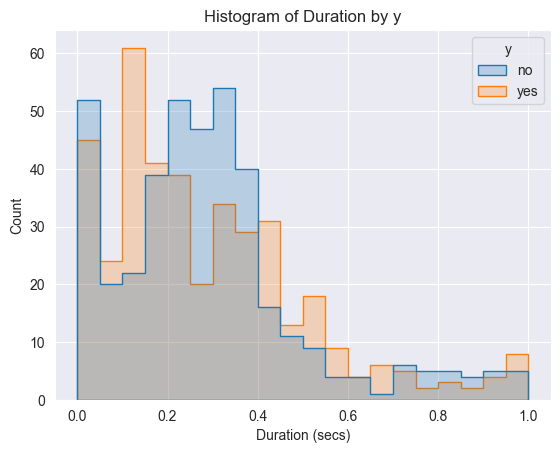

In [20]:
df = data_trimmed.to_df()

df["duration"] = df.X.apply(len) / SAMPLE_RATE

sns.histplot(data=df, x="duration", hue="y", element="step", common_norm=False)

plt.xlabel('Duration (secs)')
plt.ylabel("Count")
plt.title('Histogram of Duration by y')
plt.show()

# Pipeline - Preprocessing the audio

In [21]:
from caits.transformers import SlidingWindow
from caits.preprocessing import normalize_signal
from caits.filtering import filter_butterworth

In [22]:
sw_transformer = SlidingWindow(WS_SAMPLES, OVERLAP_SAMPLES)

In [23]:
normaliser_transformer = FunctionTransformer(normalize_signal)

In [24]:
lp_filt_transformer = FunctionTransformer(
    filter_butterworth, fs=SAMPLE_RATE, method="sosfiltfilt", filter_type="lowpass", cutoff_freq=7999, order=3
)

In [25]:
pipe_sw = Pipeline([
    ("sw", sw_transformer),
])

In [26]:
data_sw = pipe_sw.fit_transform(data_trimmed)

In [27]:
data_train, data_test = data_sw.train_test_split(test_size=0.2, stratify=True, random_state=42, shuffle=True)
data_train, data_val = data_train.train_test_split(test_size=0.2, stratify=True, random_state=42, shuffle=True)
data_train, data_test, data_val

(Dataset with 832 instances,
 Dataset with 261 instances,
 Dataset with 209 instances)

In [28]:
pipe_process = Pipeline([
    ("sw", sw_transformer),
    ("normaliser", normaliser_transformer),
    ("lp_filter", lp_filt_transformer)
])

In [29]:
# Fit transform pipeline
transformed_train = pipe_process.fit_transform(data_train)
transformed_test = pipe_process.transform(data_test)
transformed_val = pipe_process.transform(data_val)

In [30]:
X_train, y_train, files_train = transformed_train.to_numpy()
X_test, y_test, files_test = transformed_test.to_numpy()
X_val, y_val, files_val = transformed_val.to_numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((832, 3200, 1), (832,), (261, 3200, 1), (261,))

In [31]:
X_train.max(), X_train.min()

(1.0048738, -1.0010669)

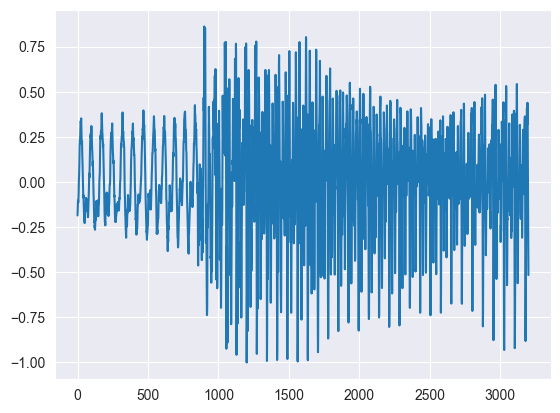

In [32]:
plt.plot(X_train[0].flatten())